# 4 PRE-PROCESAMENT # 

## Estratègia per preparar les dades ##
Un cop realitzats multiples intents, per intentar dirigir el meu projecta a l'objectiu que tenia en ment: Predicció per classificar si un local estaria amb activitat, un cop entrades diferents mètriques com el barri, districte i activitat, defineixo un nou objectiu de classificació supervisada que és detectar si un local pot ser de degustació o no. Vist l'impacte en l'estudi EDA que té, doncs és un negoci senzill que no necessita sortida de fums i desl que pot tenir més èxit donat les ratios observades.

### Definir el target (variable objectiu): SN_Servei_degustació

Variables independents (features):
Les variables categòriques (com Nom_Barri, Nom_Districte, Nom_Sector_Activitat, Nom_Grup_Activitat etc.) les codificarem amb OneHot Encoding. 
Les variables booleanes (com SN_Oci_Nocturn, SN_Coworking, SN_Servei_Degustacio, SN_Obert24h, SN_Mixtura, SN_Carrer, SN_Mercat', SN_Galeria, SN_CComercial, SN_Eix) ja estan codificades com 0/1, així que no cal fer cap transformació.   

Tècniques a tenir en compte: 
Com hem apreciat a l'EDA, comptem amb un conjunt de dades desbalancejat, hem de tenir en compte algunes tècniques per equilibrar les classes, com:  Reamostratge (Resampling), Oversampling generar més exemples de la classe minoritària (inactiu) per equilibrar la distribució de classes, ...  Una tècnica comuna és SMOTE (Synthetic Minority Over-sampling Technique), que genera mostres sintètiques de la classe minoritària. Una altra tècnica és Cost-Sensitive Learning, tècnica modifica el model per penalitzar més els errors de predicció en la classe minoritària, fent que el model estigui més "preparat" per identificar els locals inactius. 

No cal cap escalador doncs només comptem amb numèriques booleanes.   

Models a valorar: Random Forest, XGBoost, LogisticRegression, DecisionTreeClassifier i  GradientBoostingClassifier.  
Búsqueda de millors hiperparàmetres amb grid_search.   
Mesura de rendiments: A l'hora de mesurar els resultats, no només tenir en compte la precisió (accuracy), sinó també el F1-score, recall i precisió.
Obtenir una matriu de confusió amb els valors verdeders i falsos positius, negatius... 
Validació creuada estratificada.   

In [21]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import warnings

# Suprimir todas las advertencias
warnings.filterwarnings('ignore')
df = pd.read_csv('df_net.csv')

Donat el gir del meu estudi, i abans de confirmar el nou tartget, primer vull avaluar la relació de les variables per veure quines definir per la nova variable dependet SN_Degustació. En el cas de les booleanes i categòriques, aplicarem la tècnica de amb chi quadrat:

In [74]:
from scipy.stats import chi2_contingency

# Seleccionar les columnes categoriques i binàries
columnes_categoriques = ['Nom_Activitat', 'Nom_Barri']
columnes_binaries = ['SN_Carrer', 'SN_Mercat', 'SN_Galeria', 'SN_CComercial', 'SN_Eix']

# Dataframe amb les columnes seleccionades
X = df[columnes_categoriques + columnes_binaries]  # Característiques
y = df['SN_Servei_Degustacio']  # Target (binari)

# Convertir les columnes a tipus de dades categòriques si no ho són
X = X.apply(lambda col: col.astype('category') if col.dtype != 'category' else col)

# Crear un dataframe per guardar els resultats del test
resultats_chi = []

# Iterar sobre les columnes d'X per aplicar el test Chi-cuadrat
for column in X.columns:
    # Crear taula de contingència
    contingency_table = pd.crosstab(X[column], y)
    
    # Aplicar Chi-cuadrat
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    # Emmagatzemar els resultats
    resultats_chi.append({
        'Columna': column,
        'Chi2': chi2,
        'p-value': p,
        'Graus_de_Llibertat': dof
    })

# Convertir els resultats en un DataFrame
df_resultats_chi = pd.DataFrame(resultats_chi)

# Mostrar els resultats
print(df_resultats_chi)

# Filtrar les columnes amb p-value < 0.05 per identificar relacions significatives
significant_results = df_resultats_chi[df_resultats_chi['p-value'] < 0.05]

print("\nColumnes amb relació significativa amb 'SN_Servei_Degustacio':")
print(significant_results)


         Columna          Chi2       p-value  Graus_de_Llibertat
0  Nom_Activitat  19157.478808  0.000000e+00                  76
1      Nom_Barri    115.404353  8.886990e-04                  72
2      SN_Carrer     17.267305  3.247266e-05                   1
3      SN_Mercat     26.952980  2.084655e-07                   1
4     SN_Galeria      3.295482  6.947070e-02                   1
5  SN_CComercial      1.683255  1.944925e-01                   1
6         SN_Eix     17.070015  3.602666e-05                   1

Columnes amb relació significativa amb 'SN_Servei_Degustacio':
         Columna          Chi2       p-value  Graus_de_Llibertat
0  Nom_Activitat  19157.478808  0.000000e+00                  76
1      Nom_Barri    115.404353  8.886990e-04                  72
2      SN_Carrer     17.267305  3.247266e-05                   1
3      SN_Mercat     26.952980  2.084655e-07                   1
6         SN_Eix     17.070015  3.602666e-05                   1


Relacions significatives: Les variables 'Nom_Activitat', 'Nom_Barri', 'SN_Carrer', 'SN_Mercat', i 'SN_Eix' tenen una relació estadísticament significativa amb 'SN_Servei_Degustacio' (p-value < 0.05).

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66088 entries, 0 to 66087
Data columns (total 43 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID_Global                 66088 non-null  object 
 1   Codi_Principal_Activitat  66088 non-null  int64  
 2   Nom_Principal_Activitat   66088 non-null  object 
 3   Codi_Sector_Activitat     66088 non-null  int64  
 4   Nom_Sector_Activitat      66088 non-null  object 
 5   Codi_Grup_Activitat       66088 non-null  int64  
 6   Nom_Grup_Activitat        66088 non-null  object 
 7   Codi_Activitat_2022       66088 non-null  int64  
 8   Nom_Activitat             66088 non-null  object 
 9   Codi_Activitat_2016       66088 non-null  object 
 10  Nom_Local                 66088 non-null  object 
 11  SN_Oci_Nocturn            66088 non-null  int64  
 12  SN_Coworking              66088 non-null  int64  
 13  SN_Servei_Degustacio      66088 non-null  int64  
 14  SN_Obe

In [73]:
import pandas as pd
from scipy.stats import chi2_contingency

# Carregar el dataframe (suponem que ja tens el dataframe carregat com 'df')

# Seleccionar les variables categòriques per comparar amb 'SN_Servei_Degustacio'
categorical_columns = [
    'Nom_Principal_Activitat',
    'Nom_Barri',
    'Nom_Sector_Activitat',
    'Nom_Grup_Activitat',
    'Nom_Activitat'
]

# Iterar sobre les columnes categòriques per aplicar el test de chi-cuadrado
for col in categorical_columns:
    print(f"Chi-cuadrado per {col} i SN_Servei_Degustacio:")
    
    # Crear la taula de contingència
    contingency_table = pd.crosstab(df[col], df['SN_Servei_Degustacio'])
    
    # Aplicar el test de chi-cuadrado
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    # Imprimir els resultats
    print(f"p-value: {p}")
    if p < 0.05:
        print("Hi ha una associació significativa entre la variable i SN_Servei_Degustacio")
    else:
        print("No hi ha una associació significativa entre la variable i SN_Servei_Degustacio")
    print("-" * 50)


Chi-cuadrado per Codi_Sector_Activitat i SN_Servei_Degustacio:
p-value: 3.994856103833514e-235
Hi ha una associació significativa entre la variable i SN_Servei_Degustacio
--------------------------------------------------
Chi-cuadrado per Nom_Barri i SN_Servei_Degustacio:
p-value: 0.000888699036972236
Hi ha una associació significativa entre la variable i SN_Servei_Degustacio
--------------------------------------------------
Chi-cuadrado per Codi_Districte i SN_Servei_Degustacio:
p-value: 3.7014622320786514e-08
Hi ha una associació significativa entre la variable i SN_Servei_Degustacio
--------------------------------------------------
Chi-cuadrado per Nom_Grup_Activitat i SN_Servei_Degustacio:
p-value: 0.0
Hi ha una associació significativa entre la variable i SN_Servei_Degustacio
--------------------------------------------------
Chi-cuadrado per Nom_Activitat i SN_Servei_Degustacio:
p-value: 0.0
Hi ha una associació significativa entre la variable i SN_Servei_Degustacio
-----------

_Conclusió: Les variables Nom_Sector_Activitat, Nom_Grup_Activitat, i Nom_Activitat mostren una relació molt forta amb la variable objectiu. Les variables Nom_Barri i Nom_Districte també mostren una relació significativa, tot i que una mica més dèbil que les anteriors. Això vol dir que aquestes variables poden ser molt útils per a la classificació. Així, podem mantenir totes aquestes variables en el model per a la classificació._

_Relació significativa: (P-valor menor que 0.05), target (Codi_Principal_Activitat). Nom_Principal_Activitat, Nom_Sector_Activitat, o Nom_Barri poden ajudar a predir si un establiment està actiu o inactiu._

### Preparació del conjunt d'entrenament i entrenament amb difernts models ###

Dividim les variables seleccionades amb categòriques i binàries doncs les binàries no necessiten cap transformació. Les categòriques les transformem amb el OneHotEncoder i després de separar el conjunt de proba 70%, creem un pipeline per entrenar 5 models diferents de classificació supervisada

In [27]:
# Seleccionar les columnes útils del df
columnes_categoriques = ['Nom_Activitat', 'Nom_Barri']
columnes_binaries = ['SN_Carrer', 'SN_Mercat', 'SN_Galeria', 'SN_CComercial', 'SN_Eix']

# Dataframe amb les columnes seleccionades
X = df[columnes_categoriques + columnes_binaries]  # Característiques
y = df['SN_Servei_Degustacio']  # Variable objectiu

# Separar en entrenament i prova
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Crear un transformador de columnes per transformar les categoriques
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), columnes_categoriques),
        ('bin', 'passthrough', columnes_binaries)
    ])

# Definir els models
models = {
    'logistic': LogisticRegression(random_state=42, max_iter=1000),
    'decision_tree': DecisionTreeClassifier(),
    'random_forest': RandomForestClassifier(random_state=42),
    'gradient_boosting': GradientBoostingClassifier(),
    'xgboost': XGBClassifier(eval_metric='logloss', use_label_encoder=False)
}

# Crear un pipeline per a cada model
pipelines = {name: Pipeline([
    ('preprocessor', preprocessor),  # Primer preprocessem les dades
    ('classifier', model)            # Després afegim el model
]) for name, model in models.items()}

# GridSearch per a cada model
param_grids = {
    'logistic': {
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear']
    },
    'decision_tree': {
        'classifier__max_depth': [10, 20]
    },
    'random_forest': {
        'classifier__n_estimators': [100],
        'classifier__max_depth': [10, 20]
    },
    'gradient_boosting': {
        'classifier__n_estimators': [100],
        'classifier__learning_rate': [0.01, 0.1]
    },
    'xgboost': {
        'classifier__n_estimators': [100],
        'classifier__learning_rate': [0.01, 0.1]
    }
}

# Ajustar els models amb GridSearch
best_estimators = {}
for name, pipeline in pipelines.items():
    grid_search = GridSearchCV(pipeline, param_grids[name], cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_estimators[name] = grid_search.best_estimator_
    print(f'Best params for {name}: {grid_search.best_params_}')

# Avaluació dels models
for name, model in best_estimators.items():
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    print(f'--- {name} ---')
    print(f'Accuracy: {score:.2f}')
    print("Classification Report:\n", report)

Best params for logistic: {'classifier__C': 0.01, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best params for decision_tree: {'classifier__max_depth': 20}
Best params for random_forest: {'classifier__max_depth': 10, 'classifier__n_estimators': 100}
Best params for gradient_boosting: {'classifier__learning_rate': 0.01, 'classifier__n_estimators': 100}
Best params for xgboost: {'classifier__learning_rate': 0.01, 'classifier__n_estimators': 100}
--- logistic ---
Accuracy: 0.99
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     19563
           1       0.00      0.00      0.00       264

    accuracy                           0.99     19827
   macro avg       0.49      0.50      0.50     19827
weighted avg       0.97      0.99      0.98     19827

--- decision_tree ---
Accuracy: 0.99
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00 

### Relació entre el 2on Target proposat

_Tornem a tenir problemes de sobreajustament (Overfitting), al igual que ens ha passat quan hem utilitzat el target de local actiu no actiu._
Amb la qual cosa em plantejo probar altres variables y també de fer els entrenaments per separat sense utilitzar un Pipeline:

In [49]:
# Definir i entrenar el model Gradient Boosting
gradient_boosting_model = GradientBoostingClassifier(random_state=42)
gradient_boosting_model.fit(X_train, y_train)

# Prediccions i evaluació
y_pred_gb = gradient_boosting_model.predict(X_test)
print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred_gb))
print("Gradient Boosting Classification Report:\n", classification_report(y_test, y_pred_gb))


Gradient Boosting Accuracy: 0.805215110707621
Gradient Boosting Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86     13622
           1       0.72      0.61      0.66      6205

    accuracy                           0.81     19827
   macro avg       0.78      0.75      0.76     19827
weighted avg       0.80      0.81      0.80     19827



In [51]:
from sklearn.linear_model import RidgeClassifier
# Definir i entrenar el model RidgeClassifier
ridge_model = RidgeClassifier()
ridge_model.fit(X_train, y_train)

# Prediccions i evaluació
y_pred_ridge = ridge_model.predict(X_test)
print("Ridge Classifier Accuracy:", accuracy_score(y_test, y_pred_ridge))
print("Ridge Classifier Classification Report:\n", classification_report(y_test, y_pred_ridge))


Ridge Classifier Accuracy: 0.6845211075805719
Ridge Classifier Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.98      0.81     13622
           1       0.45      0.04      0.07      6205

    accuracy                           0.68     19827
   macro avg       0.57      0.51      0.44     19827
weighted avg       0.62      0.68      0.58     19827



In [52]:
# Definir i entrenar el model Logistic Regression (L1 Regularization)
logreg_model = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
logreg_model.fit(X_train, y_train)

# Prediccions i evaluació
y_pred_logreg = logreg_model.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_logreg))


Logistic Regression Accuracy: 0.6931961466686841
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.97      0.81     13622
           1       0.56      0.09      0.16      6205

    accuracy                           0.69     19827
   macro avg       0.63      0.53      0.49     19827
weighted avg       0.66      0.69      0.61     19827



In [54]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

# Definir i entrenar el model Gradient Boosting
gradient_boosting_model = GradientBoostingClassifier(random_state=42)
gradient_boosting_model.fit(X_train, y_train)

# Prediccions i evaluació
y_pred_gb = gradient_boosting_model.predict(X_test)
print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred_gb))
print("Gradient Boosting Classification Report:\n", classification_report(y_test, y_pred_gb))


Gradient Boosting Accuracy: 0.805215110707621
Gradient Boosting Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86     13622
           1       0.72      0.61      0.66      6205

    accuracy                           0.81     19827
   macro avg       0.78      0.75      0.76     19827
weighted avg       0.80      0.81      0.80     19827



In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Definir i entrenar el model Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Prediccion  i evaluació
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Classifier Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest Classifier Classification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Classifier Accuracy: 0.8166641448529782
Random Forest Classifier Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.88      0.87     13622
           1       0.72      0.68      0.70      6205

    accuracy                           0.82     19827
   macro avg       0.79      0.78      0.78     19827
weighted avg       0.81      0.82      0.82     19827



### Optimització dels hiperparàmetres amb GridSearchCV: ###

Busco els millors hiperparàmetres per a cada model. Optimitzant el rendiment del model mitjançant la cerca dels millors valors de paràmetres:

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Definimos los parámetros de búsqueda para cada modelo
param_grids = {
    'random_forest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'logistic_regression': {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    },
    'gradient_boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 10],
        'subsample': [0.8, 1.0]
    },
    'xgboost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 10],
        'subsample': [0.8, 1.0]
    }
}

# Modelos
models = {
    'random_forest': RandomForestClassifier(random_state=42),
    'logistic_regression': LogisticRegression(max_iter=1000, random_state=42),
    'gradient_boosting': GradientBoostingClassifier(random_state=42),
    'xgboost': XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
}

# GridSearch para cada modelo
best_estimators = {}

for model_name, model in models.items():
    print(f"Optimizing {model_name}...")
    grid_search = GridSearchCV(model, param_grids[model_name], cv=5, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    best_estimators[model_name] = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}\n")

# Evaluación de los mejores modelos
for model_name, model in best_estimators.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"--- {model_name} ---")
    print(f"Accuracy: {accuracy:.2f}")
    print(classification_report(y_test, y_pred))


In [83]:
import joblib

# Guardar el millor model
best_model = grid_search.best_estimator_
joblib.dump(best_model, 'best_random_forest_model.pkl')

# Imprimir els millors paràmetres
print("Millors paràmetres:", grid_search.best_params_)

Millors paràmetres: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


### Predicció final sobre el conjunt de test ###

Utilitzo els millors models, ja optimitzats amb GridSearchCV, per fer la predicció final sobre el conjunt de test i obtenir mètriques detallades com l'accuracy, precision, recall, F1-score, i la matriu de confusió:

--- Evaluando random_forest ---
Accuracy: 0.82
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87     13622
           1       0.73      0.67      0.70      6205

    accuracy                           0.82     19827
   macro avg       0.79      0.78      0.78     19827
weighted avg       0.82      0.82      0.82     19827



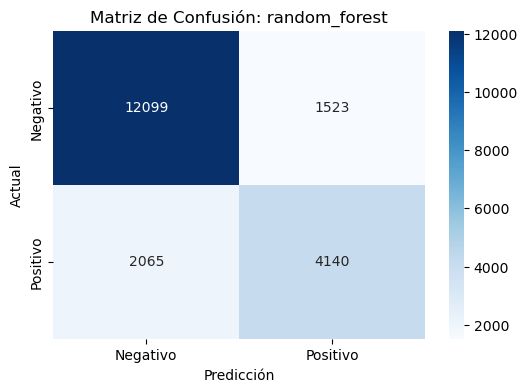

--- Evaluando logistic_regression ---
Accuracy: 0.68
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.98      0.81     13622
           1       0.45      0.04      0.07      6205

    accuracy                           0.68     19827
   macro avg       0.57      0.51      0.44     19827
weighted avg       0.61      0.68      0.58     19827



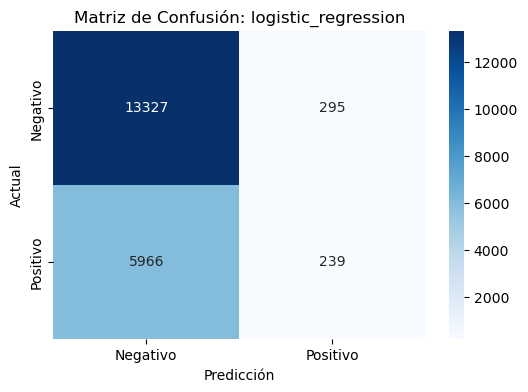

--- Evaluando gradient_boosting ---
Accuracy: 0.82
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.88      0.87     13622
           1       0.72      0.70      0.71      6205

    accuracy                           0.82     19827
   macro avg       0.79      0.79      0.79     19827
weighted avg       0.82      0.82      0.82     19827



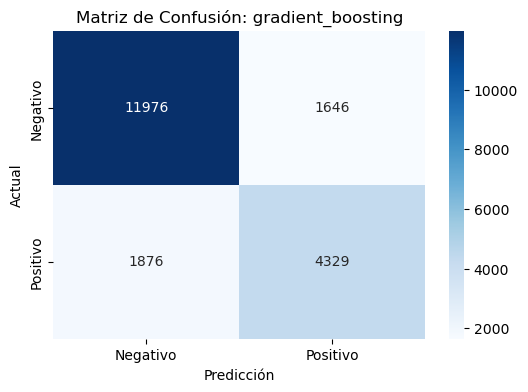

--- Evaluando xgboost ---
Accuracy: 0.82
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.88      0.87     13622
           1       0.72      0.70      0.71      6205

    accuracy                           0.82     19827
   macro avg       0.79      0.79      0.79     19827
weighted avg       0.82      0.82      0.82     19827



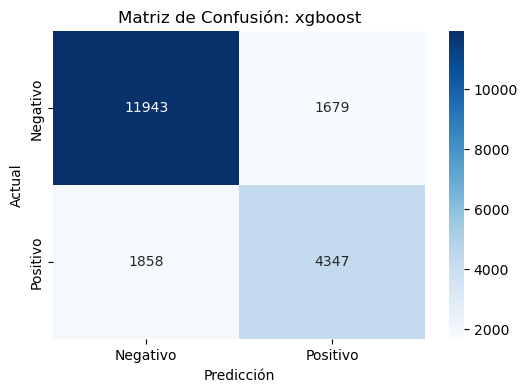

In [57]:
# Evaluació dels millors models amb les millors configuracions
for model_name, model in best_estimators.items():
    print(f"--- Evaluando {model_name} ---")
    
    # Entrenar el modelo con los mejores hiperparámetros
    model.fit(X_train, y_train)
    
    # Realizar predicciones
    y_pred = model.predict(X_test)
    
    # Evaluación: Exactitud
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")
    
    # Reporte de clasificación
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    
    # Visualización de la matriz de confusión
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
    plt.title(f'Matriz de Confusión: {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicción')
    plt.show()

    Comparativa General:
- Millor precisió: Tots els models tenen una precisió global de 0.82, a excepció de la Regressió Logística que té 0.68 (l'hem de descartar)
Millor rendiment per a la classe 0 (negativa): Tots els models mostren un bon recall i precisió per a la classe 0, destacant-se el model "Regressió Logística" pel seu recall molt alt a la classe 0.   
- Millor rendiment per a la classe 1 (positiva): Random Forest, Gradient Boosting i XGBoost tenen un rendiment força equilibrat entre les dues classes amb un F1-Score d'aproximadament 0.70 per a la classe positiva. No obstant això, la Regressió Logística mostra un rendiment molt deficient per a la classe 1.     
    Observacions:  
Regressió Logística: Tot i la seva precisió en la classe negativa, el model no és efectiu, un ajust de classes o tècniques com SMOTE o ponderació de classes podrien millorar el model, però estem molt lluny d'un bon resultat.

Random Forest, Gradient Boosting, XGBoost: Tots aquests models mostren un rendiment similar i són millors per gestionar el desbalanç de classes.  
Random Forest pot tenir un bon rendiment fins i tot sense molta optimització.  
Gradient Boosting i XGBoost poden millorar amb un bon ajust de paràmetres.

### Provem SMOTE per veure si millorem el resultat, doncs equilibra les classes en el conjunt d'entrenament ###

In [68]:
from imblearn.over_sampling import SMOTE
# Aplicar SMOTE per equilibrar les classes en el conjunt d'entrenament
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Crear el model amb pesatge de classes
model = RandomForestClassifier(class_weight='balanced', random_state=42)

# Entrenar el model
model.fit(X_train_res, y_train_res)

# Realitzar prediccions
y_pred = model.predict(X_test)

# Avaluar el model
accuracy = accuracy_score(y_test, y_pred)
print(f"Exactitud després de SMOTE: {accuracy:.2f}")
print("Report de classificació:\n", classification_report(y_test, y_pred))


Exactitud després de SMOTE: 0.78
Report de classificació:
               precision    recall  f1-score   support

           0       0.91      0.76      0.83     13622
           1       0.61      0.83      0.71      6205

    accuracy                           0.78     19827
   macro avg       0.76      0.80      0.77     19827
weighted avg       0.82      0.78      0.79     19827



### Provem PCA tot i que no crec que sigui la solució doncs no veig necessaria una reducció de components ###

In [69]:
from sklearn.decomposition import PCA

# Apliquem PCA a 2 components (per exemple)
pca = PCA(n_components=2)
X_train_res_pca = pca.fit_transform(X_train_res)
X_test_pca = pca.transform(X_test)


In [70]:
# Entrenar el model després d aplicar PCA i SMOTE
model = RandomForestClassifier(random_state=42)
model.fit(X_train_res_pca, y_train_res)

# Realitzar prediccions
y_pred = model.predict(X_test_pca)

# Avaluar el rendiment
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.91      0.76      0.83     13622
           1       0.61      0.83      0.70      6205

    accuracy                           0.78     19827
   macro avg       0.76      0.79      0.77     19827
weighted avg       0.81      0.78      0.79     19827



### Conclusió: 
_SMOTE ha estat efectiu per millorar el recall de la classe positiva (1), però ha fet que l'exactitud global baixés una mica.
PCA, en aquest cas, sembla no haver tingut un impacte significatiu ni per bé ni per malament._

### Pròxims passos per millores: 

- Provar SMOTE amb altres models com XGBoost o Gradient Boosting per veure si aquests models poden aprofitar millor l'augment de la classe minoritària.
- Experimentar amb tècniques alternatives com el balanceig de classes per pes o l'ús de models més sensibles al desbalanç de classes (per exemple, models amb ponderació de classes).
- Cross Validation per reduir el sobreajustament